In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from calib import logger
from pathlib import Path
import torch
import numpy as np
from calib.calib.datasets import get_dataset
from omegaconf import OmegaConf
from calib.calib.utils.experiments import load_experiment
from calib.calib.utils.helper_functions import *
from calib.calib.datasets.viz_2d import *
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm
import pandas as pd

In [4]:
!pip show torch torchvision
# !nvidia-smi

Name: torch
Version: 1.11.0+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /cluster/home/alpaul/.local/lib/python3.7/site-packages
Requires: typing-extensions
Required-by: nade, torchmetrics, torchvision
---
Name: torchvision
Version: 0.12.0+cu113
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /cluster/home/alpaul/.local/lib/python3.7/site-packages
Requires: numpy, pillow, requests, torch, typing-extensions
Required-by: nade


In [4]:
data_dir = '/cluster/project/infk/cvg/students/alpaul/DeepSingleImageCalibration/external/my_external_images_pitch/'
results_dir = '/cluster/project/infk/cvg/students/alpaul/DeepSingleImageCalibration/external/results_pitch/'

In [5]:
experiment = 'colab_exp5_4_heads'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
roll_centers, rho_centers, fov_centers, k1_hat_centers = get_bin_centers(device)
conf = '/cluster/home/alpaul/DeepSingleImageCalibration/calib/calib/configs/external_test_config.yaml'
logger.info(f'Starting test {experiment}')
conf = OmegaConf.merge(OmegaConf.load(conf), {'data': {'data_dir': data_dir}})
dataset = get_dataset(conf.data.name)(conf.data)
test_loader = dataset.get_data_loader('test')
model = load_experiment(experiment, conf.model).eval()

results = []

for data in tqdm.tqdm(test_loader, desc='Testing', ascii=True, disable=False):
    pred = model(data)
    output = pred['roll']
    entropy = compute_categorical_entropy(output)
    pred['roll_entropy'] = entropy
    pred_class = output.argmax(1)
    pred_deg = torch.tensor(roll_centers[pred_class], dtype=torch.float64, device=device)
    pred['roll'] = pred_deg

    output = pred['rho']
    entropy = compute_categorical_entropy(output)
    pred['rho_entropy'] = entropy
    pred_class = output.argmax(1)
    pred_norm_rho = torch.tensor(rho_centers[pred_class], dtype=torch.float64, device=device)
    pred_ratio_rho = pred_norm_rho * 0.35
    pred['rho'] = pred_ratio_rho

    output = pred['vfov']
    entropy = compute_categorical_entropy(output)
    pred['vfov_entropy'] = entropy
    pred_class = output.argmax(1)
    pred_fov_deg = torch.tensor(fov_centers[pred_class], dtype=torch.float64, device=device)
    pred['vfov'] = pred_fov_deg

    output = pred['k1_hat']
    entropy = compute_categorical_entropy(output)
    pred['k1_hat_entropy'] = entropy
    pred_class = output.argmax(1)
    pred_k1_hat = torch.tensor(k1_hat_centers[pred_class], dtype=torch.float64, device=device)
    pred['k1_hat'] = pred_k1_hat
    result = {'path': data['path'],
              **{'pred_'+str(pred_key):pred[pred_key].unsqueeze(0).cpu().item() # TODO: Clean this
                  if isinstance(pred[pred_key],torch.Tensor)
                  else pred[pred_key]
                  for pred_key in pred}
                    }
    results.append({ **result, 'image': data['image'].numpy().squeeze(0).transpose((1, 2, 0))})
    pd.DataFrame(result).T.to_csv(Path(results_dir,str(Path(data['path'][0]).stem)+'.csv'), header=False, index=True)


[04/05/2023 09:09:57 calib INFO] Starting test colab_exp5_4_heads


NameError: name 'data_dir' is not defined

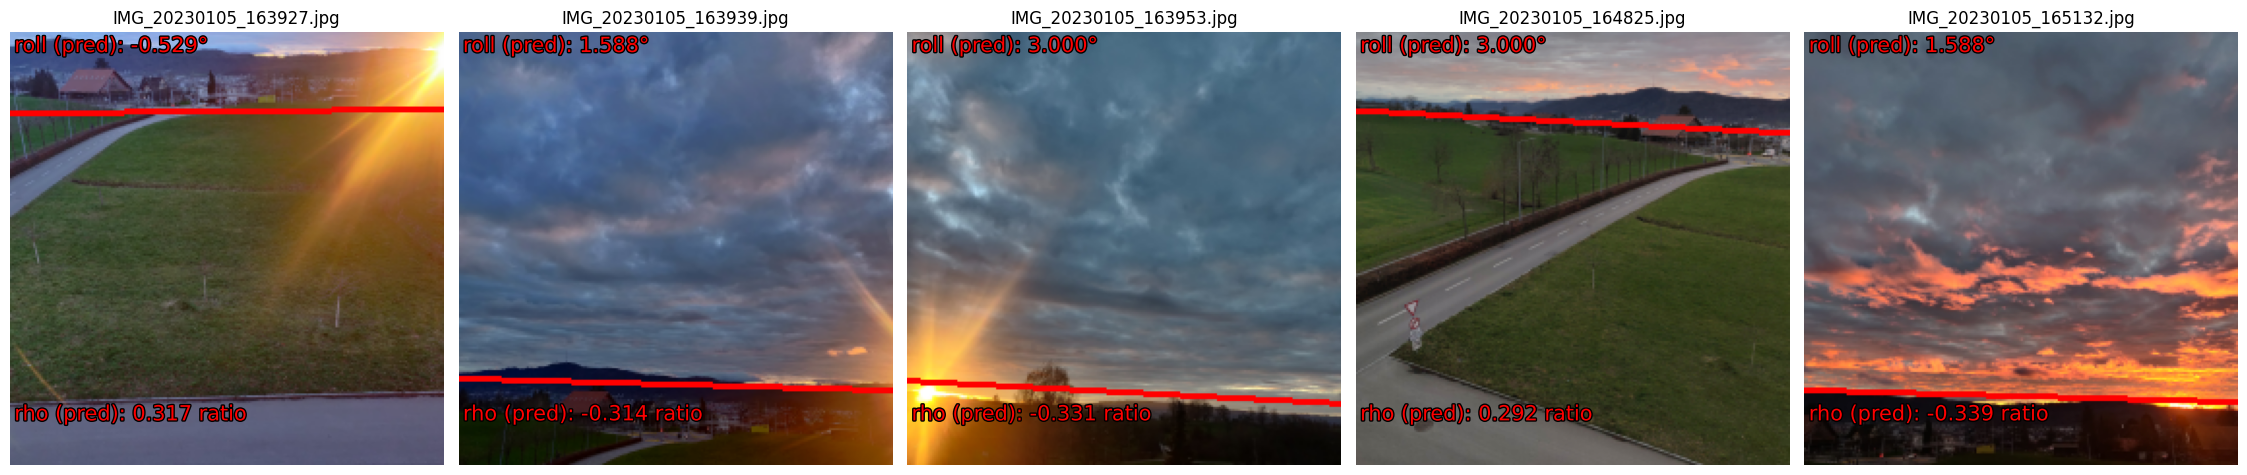

In [6]:
plot_row(results[0:10], pred_annotate=['roll','rho'], titles=[d['path'][0].split('/')[-1] for d in results])